In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.append('..')
from xDL.models.FTTransformer import FTTransformer

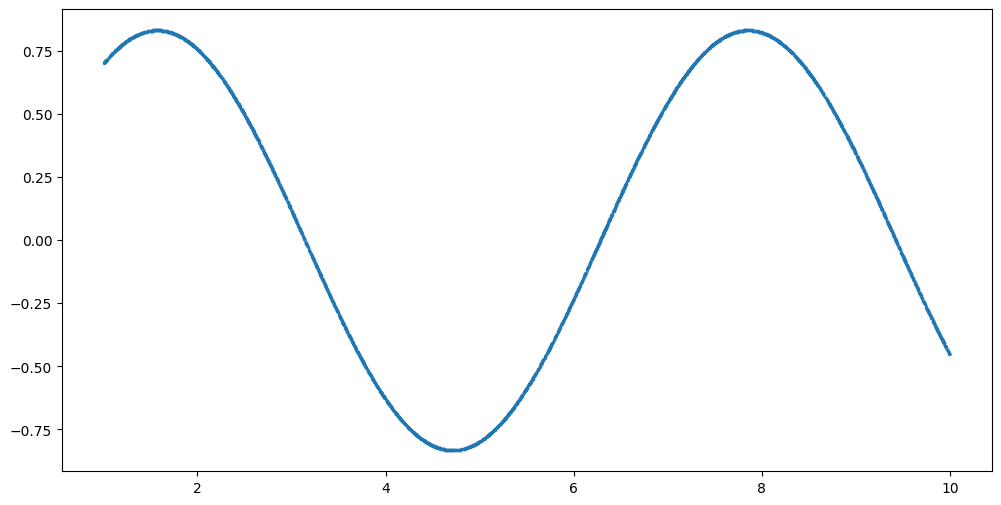

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(101)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B']

# Generate random categorical data as an array of strings
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    return 5*np.sin(x) 

def func2(x):
    return -(2*(x-3))**2 


# Create mappings for categorical values
category_map1 = {'A': 0.5, 'B': -0.5}
category_map2 = {'Yes': 0.5, 'No': -0.5, 'Maybe': 0}

# Calculate y by combining continuous and categorical functions
#
y = func1(X1) / 6 + func2(X2)/6  +  (func1(X1)*func2(X2))/25 + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2) + np.random.normal(0, 0.2, size=num_samples) 


data = pd.DataFrame({"Target": y, 'Category1': categorical1, 'Category2': categorical2, 'Continuous1':X1, 'Continuous2':X2})

# Plot each input variable against the target variable
plt.figure(figsize=(12, 6))



plt.scatter(X1, func1(X1)/6, alpha=0.5, s=2)


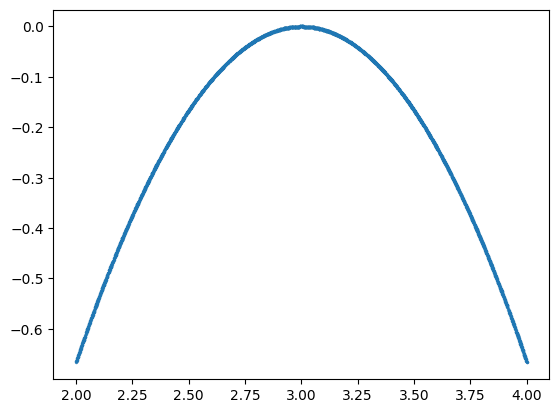

In [4]:
plt.scatter(X2, func2(X2)/6, alpha=0.5, s=2)

In [5]:
model = FTTransformer(
    data=data, 
    y="Target",
    output_activation="linear",
    binning_task="regression",
    num_encoding="PLE",
    n_bins_num=50,
    batch_size=5000,
    dropout=0.5,
    attn_dropout=0.5,
    ff_dropout=0.5,
    embedding_dim=64
    )

In [6]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=50, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 14.6976 - output_loss: 14.6976 - output_mse: 14.6976 - val_loss: 15.0790 - val_output_loss: 15.0790 - val_output_mse: 15.0790
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 14.7018 - output_loss: 14.7018 - output_mse: 14.7018 - val_loss: 14.0286 - val_output_loss: 14.0286 - val_output_mse: 14.0286
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 14.4827 - output_loss: 14.4827 - output_mse: 14.4827 - val_loss: 13.7919 - val_output_loss: 13.7919 - val_output_mse: 13.7919
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 14.0179 - output_loss: 14.0179 - output_mse: 14.0179 - val_loss: 13.2723 - val_output_loss: 13.2723 - val_output_mse: 13.2723
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 13.7945 - output_loss: 13.7945 - output_mse: 13.7945 - val_loss: 12.2597 - val_output_loss: 12.2597 - val_output_mse: 12.2597
Epoch 6/50
1/1 [=========

5/5 [==============================] - 1s 144ms/step


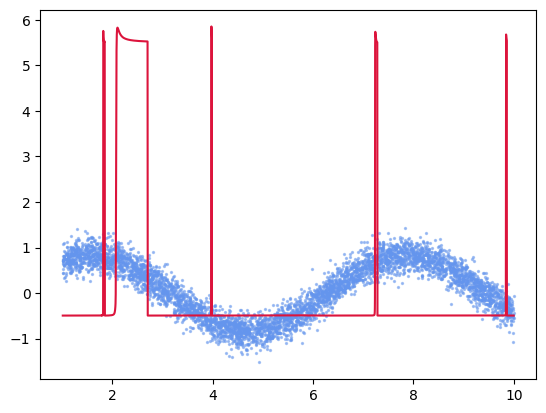

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from xDL.utils.data_utils import *
dataset = model.data.copy()
dataset["Category1"] = np.repeat("Unkown", len(dataset))
dataset["Category2"] = np.repeat("Unkown", len(dataset))

dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
dataset["Continuous2"] = np.linspace(-30, -10, len(dataset))
input_dict = model.input_dict.copy()
input_dict["Continuous2"]["encoding"] = "PLE"
dataset = df_to_dataset(
            dataset,
            model.data,
            input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)



preds = model.predict(dataset)
preds = preds["output"].squeeze()
plt.scatter(model.data["Continuous1"], func1(X1)/6 + np.random.normal(0, 0.2, size=num_samples), s=2,
                    alpha=0.5,
                    color="cornflowerblue")
plt.plot(np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(preds)), preds, color="crimson")

5/5 [==============================] - 1s 151ms/step


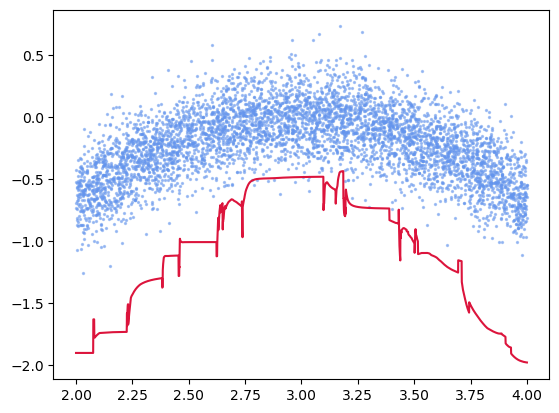

In [640]:
dataset = model.data.copy()
dataset["Category1"] = np.repeat("Unkown", len(dataset))
dataset["Category2"] = np.repeat("Unkown", len(dataset))

dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))

input_dict = model.input_dict.copy()
input_dict["Continuous2"]["encoding"] = "PLE"
dataset = df_to_dataset(
            dataset,
            model.data,
            input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)
preds = model.predict(dataset)
preds = preds["output"].squeeze()


plt.scatter(model.data["Continuous2"], func2(X2)/6 + np.random.normal(0, 0.2, size=num_samples), s=2,
                    alpha=0.5,
                    color="cornflowerblue")
plt.plot(np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(preds)), preds-1.1, color="crimson")

In [641]:
inputs = []
for key, val in model.inputs.items():
    inputs.append(val)

In [642]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



# Define the MLP model

x = layers.concatenate(inputs)  # Concatenate all inputs
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='linear', name='output')(x)

mlp = keras.Model(inputs=inputs, outputs=output)

# Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print model summary to see input names
mlp.summary()

# Train the model on the TensorFlow dataset
mlp.fit(model.training_dataset, validation_data=model.validation_dataset, epochs=100)


Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Category1 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Category2 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Continuous1 (InputLayer)    [(None, 50)]                 0         []                            
                                                                                                  
 Continuous2 (InputLayer)    [(None, 50)]                 0         []                            
                                                                                           

5/5 [==============================] - 0s 4ms/step


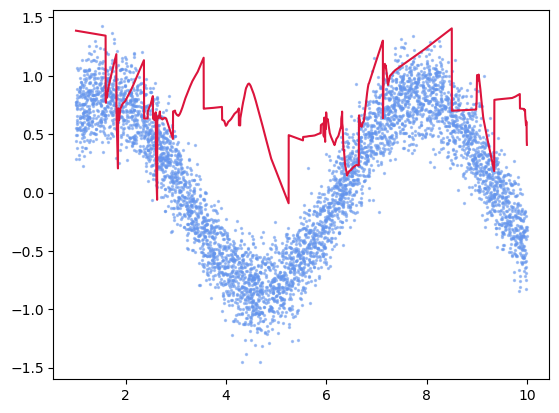

In [643]:
import numpy as np
import matplotlib.pyplot as plt
from xDL.utils.data_utils import *
dataset = model.data.copy()
dataset["Category1"] = np.repeat("Unkown", len(dataset))
dataset["Category2"] = np.repeat("Unkown", len(dataset))

dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
dataset["Continuous2"] = np.linspace(-30, -10, len(dataset))
input_dict = model.input_dict.copy()
input_dict["Continuous2"]["encoding"] = "PLE"
dataset = df_to_dataset(
            dataset,
            model.data,
            input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)
preds = mlp.predict(dataset)

plt.scatter(model.data["Continuous1"], func1(X1)/6 + np.random.normal(0, 0.2, size=num_samples), s=2,
                    alpha=0.5,
                    color="cornflowerblue")
plt.plot(np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(preds)), preds + 0.75, color="crimson")

5/5 [==============================] - 0s 4ms/step


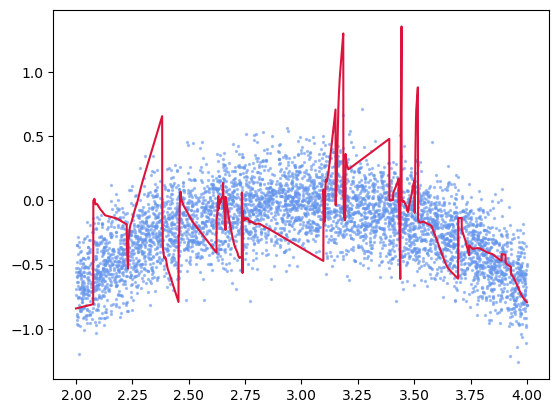

In [644]:
dataset = model.data.copy()
dataset["Category1"] = np.repeat("Unkown", len(dataset))
dataset["Category2"] = np.repeat("Unkown", len(dataset))

dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))

input_dict = model.input_dict.copy()
input_dict["Continuous2"]["encoding"] = "PLE"
dataset = df_to_dataset(
            dataset,
            model.data,
            input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)
preds = mlp.predict(dataset)


plt.scatter(model.data["Continuous2"], func2(X2)/6 + np.random.normal(0, 0.2, size=num_samples), s=2,
                    alpha=0.5,
                    color="cornflowerblue")
plt.plot(np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(preds)), preds, color="crimson")

In [645]:
MLP = [
{"ll": -1070.6843078577226, "AUC": 0.6885132193565369, "CRPS": 0.3289978814770082, "Wasserstein": 0.10345172273146709},
{"ll": -1067.5985623677207, "AUC": 0.6916993856430054, "CRPS": 0.30714608599874355, "Wasserstein": 0.10289220846588634},
{"ll": -1135.451248161674,  "AUC": 0.6703908443450928, "CRPS": 0.30469139561987113, "Wasserstein": 0.11734437332360138},
{"ll": -1100.5301598551932, "AUC": 0.6985498070716858, "CRPS": 0.2941013478610752,  "Wasserstein": 0.12925336310219793},
{"ll": -1083.2653747180975, "AUC": 0.7078884840011597, "CRPS": 0.29903582056053923, "Wasserstein": 0.10042076265958261}
]

auc = []
crps = []

for result in MLP:
    auc.append(result["AUC"])
    crps.append(result["CRPS"])

print("AUC", np.mean(auc), np.std(auc))

print("CRPS", np.mean(crps), np.std(crps))

AUC 0.691408348083496 0.012432194118056294
CRPS 0.3067945063034475 0.01199041306734496


In [653]:
MLP = [
{"LL": 30461.123481910796, "Gamma Deviance": 1.4265202021852696, "KL_Div": 5.741150856018066,   "Wasserstein Distance": 152.0165409071228},
{"LL": 35318.20174744948,  "Gamma Deviance": 1.2835454475191859, "KL_Div": 6.2148213386535645,  "Wasserstein Distance": 221.8048640849841},
{"LL": 61261.48058612945,  "Gamma Deviance": 0.8159966766728369, "KL_Div": 5.578059196472168,   "Wasserstein Distance": 123.9700941103825},
{"LL": 49589.55836062774,  "Gamma Deviance": 0.5038153472756847, "KL_Div": 2.8479347229003906,  "Wasserstein Distance": 79.83697441227298},
{"LL": 58758.86867843733,  "Gamma Deviance": 420308.43175023096, "KL_Div": 5.23057746887207,    "Wasserstein Distance": 99.68177936169673},
]
XGBOOST = [
{"LL": 21736.914479152172, "Gamma Deviance": 1.811586591010074,  "KL_Div": 5.797798156738281,  "Wasserstein Distance": 92.579975289326},
{"LL": 22811.95628244244,  "Gamma Deviance": 1.4933338484342384, "KL_Div": 6.06115198135376,   "Wasserstein Distance": 162.07144292665},
{"LL": 21918.92829014237,  "Gamma Deviance": 0.8289743108852833, "KL_Div": 5.820164680480957,  "Wasserstein Distance": 91.060918811926},
{"LL": 65517.231145916856, "Gamma Deviance": 0.4227081907830405, "KL_Div": 2.910442352294922,  "Wasserstein Distance": 44.738689653135},
{"LL": 21393.4501774495,   "Gamma Deviance": 0.883270382354246,  "KL_Div": 5.580944538116455,  "Wasserstein Distance": 87.670394057640},
]
NAM = [
{"LL": 31026.240535700086, "Gamma Deviance": 6.588611168352721e+26,  "KL_Div": 5.676055908203125,  "Wasserstein Distance": 122.2093537519681},
{"LL": 39959.847163532264, "Gamma Deviance": 11040937685759.709,     "KL_Div": 6.009641647338867,  "Wasserstein Distance": 182.5368869272447},
{"LL": 89191.32440803378,  "Gamma Deviance": 8.90900899573191e+23,   "KL_Div": 5.432011127471924,  "Wasserstein Distance": 122.9494378103765},
{"LL": 92327.04728972483,  "Gamma Deviance": 2.3333869801891646e+34, "KL_Div": 0.8604879379272461, "Wasserstein Distance": 81.78049013779923},
{"LL": 68218.55415449354,  "Gamma Deviance": 1.3366837156509953e+28, "KL_Div": 5.049967288970947,  "Wasserstein Distance": 104.7091434848576},
]
EBM = [
{"LL": 20693.999989126223, "Gamma Deviance": 2.340313366589651,   "KL_Div": 5.8892903327941895, "Wasserstein Distance": 101.1040105727893},
{"LL": 21161.118512540277, "Gamma Deviance": 1.4276374880403713,  "KL_Div": 6.125360012054443,  "Wasserstein Distance": 169.1336823528308},
{"LL": 20577.34733043096,  "Gamma Deviance": 0.830883147510835,   "KL_Div": 5.900798320770264,  "Wasserstein Distance": 99.01718914566335},
{"LL": 20506.34698397163,  "Gamma Deviance": 0.43156458967501937, "KL_Div": 4.339306831359863,  "Wasserstein Distance": 56.04949406247272},
{"LL": 20581.501926164827, "Gamma Deviance": 1.0005533011953898,  "KL_Div": 5.672048568725586,  "Wasserstein Distance": 95.60727087343008},
]
NodeGAM = [
{"LL": 20927.51402350536,  "Gamma Deviance": 1.8029946529358107,  "KL_Div": 5.937500476837158,  "Wasserstein Distance": 105.5309228544922},
{"LL": 21554.94319188159,  "Gamma Deviance": 1.4246843611349638,  "KL_Div": 6.179159641265869,  "Wasserstein Distance": 175.6971454456948},
{"LL": 20806.347456287196, "Gamma Deviance": 0.8240429463804008,  "KL_Div": 5.954611778259277,  "Wasserstein Distance": 103.0801700812959},
{"LL": 20915.539379606038, "Gamma Deviance": 0.46084586311467424, "KL_Div": 4.517280101776123,  "Wasserstein Distance": 59.95013495145368},
{"LL": 21034.213885520865, "Gamma Deviance": 1.0364598159634948,  "KL_Div": 5.734802722930908,  "Wasserstein Distance": 100.7815988046894},
]
DDNN = [
{"LL": 21005.392578125, "Gamma Deviance": 0.9427362527381409, "KL_Div": 5.185816287994385,    "Wasserstein Distance": 256.3892229893356},
{"LL": 21107.509765625, "Gamma Deviance": 1.5397546057358935, "KL_Div": 5.602282524108887,    "Wasserstein Distance": 323.2088847698095},
{"LL": 20800.59765625,  "Gamma Deviance": 0.9438089378369443, "KL_Div": 5.253805160522461,    "Wasserstein Distance": 252.7060651638590},
{"LL": 20962.47265625,  "Gamma Deviance": 0.6046442588763653, "KL_Div": 0.20796313881874084,  "Wasserstein Distance": 209.0377017649561},
{"LL": 20948.142578125, "Gamma Deviance": 0.9039238698214761, "KL_Div": 4.783555030822754,    "Wasserstein Distance": 245.4893254976948},
]
NAMLSS = [
{"LL": 21027.810546875, "Gamma Deviance": 0.9428572697443661, "KL_Div": 5.278640270233154,   "Wasserstein Distance": 256.524007712016},
{"LL": 21109.876953125, "Gamma Deviance": 1.438631215449061,  "KL_Div": 5.63920259475708,    "Wasserstein Distance": 323.4634145309858},
{"LL": 20817.95703125,  "Gamma Deviance": 0.941867120243056,  "KL_Div": 5.30327844619751,    "Wasserstein Distance": 252.8180529182798},
{"LL": 20960.509765625, "Gamma Deviance": 0.5920665840285994, "KL_Div": 0.08997141569852829, "Wasserstein Distance": 209.0753436502833},
{"LL": 20950.43359375,  "Gamma Deviance": 0.8940982380585505, "KL_Div": 4.842281341552734,   "Wasserstein Distance": 245.6910390848589},
]
NA2MLSS = [
{"LL": 21012.275390625, "Gamma Deviance": 0.9631384124588139, "KL_Div": 5.190236568450928,    "Wasserstein Distance": 256.3234433919321},
{"LL": 21116.404296875, "Gamma Deviance": 1.4571833882826504, "KL_Div": 5.597091197967529,    "Wasserstein Distance": 323.3431970783661},
{"LL": 20802.025390625, "Gamma Deviance": 0.9477549438127629, "KL_Div": 5.250584602355957,    "Wasserstein Distance": 252.6556458194882},
{"LL": 20942.94140625,  "Gamma Deviance": 0.566198791738851,  "KL_Div": 0.09349526464939117,  "Wasserstein Distance": 208.9275884648724},
{"LL": 20944.62109375,  "Gamma Deviance": 0.8947400708107456, "KL_Div": 4.783163070678711,    "Wasserstein Distance": 245.5623735843248},
]


In [657]:
my_models = ["MLP", "XGBOOST", "NAM", "EBM", "NodeGAM", "DDNN", "NAMLSS", "NA2MLSS"]
mylist = [MLP, XGBOOST, NAM, EBM, NodeGAM, DDNN, NAMLSS, NA2MLSS]

for name, model_ in zip(my_models, mylist):
    auc = []
    crps = []

    for result in model_:

        auc.append(result["Gamma Deviance"])
        crps.append(result["KL_Div"])

    print(name, "Gamma :", np.round(np.mean(auc), 3), np.round(np.std(auc),3), "KL:", np.round(np.mean(crps),2), np.round(np.std(crps), 2))


MLP Gamma : 84062.492 168122.97 KL: 5.12 1.18
XGBOOST Gamma : 1.088 0.498 KL: 5.23 1.17
NAM Gamma : 4.666776765696164e+33 9.333546518099134e+33 KL: 4.61 1.9
EBM Gamma : 1.206 0.651 KL: 5.59 0.64
NodeGAM Gamma : 1.11 0.466 KL: 5.66 0.59
DDNN Gamma : 0.987 0.304 KL: 4.21 2.02
NAMLSS Gamma : 0.962 0.272 KL: 4.23 2.09
NA2MLSS Gamma : 0.966 0.285 KL: 4.18 2.06
